In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
import pickle, json
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd

from utils.search_space import model_mapping

from dataset_generation.val_dataset import Datasetval as Dataset_


In [ ]:
MAIN_DIR = Path(os.getcwd()).parent
CURRENT_DIR = Path(os.getcwd())
path = Path("./m5C_Human_Basic_Site_Information/m5C_H.sapiens_basical_information.txt")
df = pd.read_csv(path, sep=" ", header=None, usecols=[x for x in range(15)])
df = df[~df[10].str.contains("N")]
dictionary_experiments = {x[0][0]: x[1].to_list() for x in df.groupby([13])[10] if x[0][0].startswith("GSE")}


In [ ]:

path_config = Path("./models_params/Transformer_config.json")
path_model =  Path("./logs/Transformer_41nts/Transformer_epoch_23.pt")

with open(path_config, 'r') as f:
    config = json.load(f)

model_name = config["model"]
model_params = config["model_params"]

model = model_mapping(model_name)(**model_params)
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
model = model.cuda()
model.eval()


Transformer_classifier(
  (input_proj): Linear(in_features=4, out_features=600, bias=False)
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-3): 4 x TransformerBlock(
        (mh_attn): FlashMultiHeadSelfAttention(
          (rotary_emb): RotaryEmbedding()
          (flash_self_attn): FlashAttention()
          (Wqkv): Linear(in_features=600, out_features=1800, bias=False)
          (attention_dropout): Dropout(p=0.1, inplace=False)
          (out_proj): Linear(in_features=600, out_features=600, bias=False)
        )
        (attn_layer_norm): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
        (transition): Sequential(
          (0): SwiGLU(
            (linear): Linear(in_features=600, out_features=1600, bias=True)
            (linear_gate): Linear(in_features=600, out_features=1600, bias=True)
          )
          (1): Dropout(p=0.0, inplace=False)
          (2): Linear(in_features=1600, out_features=600, bias=True)
        )
        (out_layer_norm): Laye

In [5]:

from dataset_generation.tokenizer import tokenize_sequences

dictionary_experiments_tokenized = {}
for name_exp, list_of_sequences in dictionary_experiments.items():
    dictionary_experiments_tokenized[name_exp] = tokenize_sequences(list_of_sequences, embed="one_hot", kmer=1)

In [6]:
full_results = {}
for name_exp, list_of_sequences in dictionary_experiments.items():

    full_tensor = torch.tensor(dictionary_experiments_tokenized[name_exp], dtype=torch.float)
    batch_size = 32
    n_batches = full_tensor.shape[0] // batch_size + 1 if full_tensor.shape[0] % batch_size != 0 else full_tensor.shape[0] // batch_size
    all_input_ids = []
    all_preds = []
    all_probs = []
    for i in range(n_batches):
        input_ids = full_tensor[i*batch_size:i*batch_size + batch_size].cuda()
        if len(input_ids.shape) < 3:
            input_ids.unsqueeze(0)
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                logits = model(input_ids)
                preds = torch.argmax(logits, dim=1)
                probs = F.softmax(logits, dim=1)

        all_input_ids.append(input_ids.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

    all_input_ids = torch.cat(all_input_ids, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_probs = torch.cat(all_probs, dim=0).numpy()

    full_results[name_exp] = {"input_ids": all_input_ids,
                                "all_preds": all_preds,
                                "all_probs": all_probs,
                                }


In [7]:
all_preds = []
all_input_ids = []
for name_exp, results in full_results.items():
    predictions = full_results[name_exp]["all_preds"]
    input_ids = full_results[name_exp]["input_ids"]
    all_input_ids.append(input_ids)
    all_preds.append(predictions)

all_input_ids = np.vstack(all_input_ids)
all_preds = np.concatenate(all_preds)

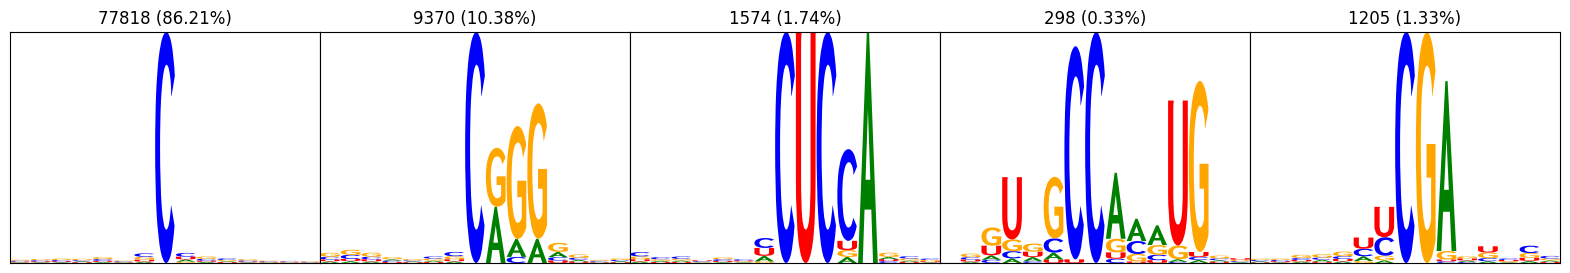

In [ ]:
import matplotlib.pyplot as plt
import logomaker
n = 5

fig, axes = plt.subplots(1, n,
                         figsize=(4*n, 3),
                         sharex=False, sharey=False)
fig.subplots_adjust(hspace=0, wspace=0)


class_names = ["Negative", "Type I", "Type II", "Type III", "Type IV"]
n = len(class_names)
for i in range(n):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    
    idxs = np.where((all_preds == i))[0]
    ax.set_title(f"{len(idxs)} ({100*len(idxs)/len(all_preds):.2f}%)")
    if len(idxs) < 40:
            #color in gray
            ax.set_facecolor("lightgray")
            ax.text(0.5, 0.5, f"n = {len(idxs)}", ha='center', va='center', fontsize=12)
            continue
    current = all_input_ids[idxs]
    pwm = np.sum(current, axis=0) / np.sum(np.sum(current, axis=0), axis=-1).reshape(-1, 1)
    pwm = pwm[pwm.shape[0]//2 - 7: pwm.shape[0]//2 + 8]
    pwm = pwm + 1e-9
    pwm = pwm / np.sum(pwm, axis=-1).reshape(-1, 1)
    pwm = pd.DataFrame(pwm, columns=["A","C","G","U"])
    info_df = logomaker.transform_matrix(pwm,
                                     from_type='probability',
                                     to_type='information')
        
    logo = logomaker.Logo(info_df, ax=ax, font_name='inconsolata',)
to_save = CURRENT_DIR / "results/atlas_analysis/atlas_motifs_transformer.pdf"
plt.savefig(to_save, bbox_inches='tight')

In [ ]:
pws_dir = MAIN_DIR / "dataset/pwms_of_full_dataset.pickle"

with open(pws_dir, "rb") as file:
    pwms = pickle.load(file)

padded_pwms = {}
for motif_id, pwm_ in pwms.items():
    padded_pwm_ = np.vstack([np.array(pwm_),np.full(15,0)])
    padded_pwm_ = (padded_pwm_ + 0.001) / (np.sum(padded_pwm_, axis=0) + 0.005)
    padded_pwms[motif_id] = padded_pwm_


padded_pwm_negatives = padded_pwms["negative"]
padded_pwm_positives_dict = {motif_id: padded_pwm for motif_id, padded_pwm in padded_pwms.items() if motif_id != "negative"}
map_letters = {"A": 0, "C": 1, "G": 2, "T": 3, "P": 4}
map_letters_reverse = {v: k for k, v in map_letters.items()}
dictionary_experiments_num = {name_exp: np.array([[map_letters[letter] for letter in seq[13:-13]] for seq in list_of_sequences]) 
                              for name_exp, list_of_sequences in dictionary_experiments.items()}

In [11]:
from collections import defaultdict
full_results_motifs = defaultdict(list)
mapping_pos = {"Type I": [7,12], "Type II": [6,12], "Type III": [3,13], "Type IV": [5,13]}

for name_exp, list_of_sequences in dictionary_experiments_num.items():
    for motif_num in list_of_sequences:
        res_now = {}
        for motif_id, padded_pwm_positives in padded_pwm_positives_dict.items():
            indexes = mapping_pos[motif_id]
            likelihoods = padded_pwm_positives[motif_num[indexes[0]:indexes[1]],np.arange(indexes[0],indexes[1])] / padded_pwm_negatives[motif_num[indexes[0]:indexes[1]],np.arange(indexes[0],indexes[1])]
            log_likelihoods = np.log2(likelihoods)
            score = np.sum(log_likelihoods) / (indexes[1] - indexes[0])
            res_now[motif_id] = score
        seq  = "".join([map_letters_reverse[x] for x in motif_num])
        full_results_motifs[name_exp].append((seq, res_now))



# mapping_clusters = {seq_id: max(x, key=x.get) for seq_id, x in all_scores.items() if max(x.values()) > 0}

full_results_motifs = {k: [(seq, max(type_, key=type_.get)) if type_[max(type_, key=type_.get)] > 0 else (seq, "negative") 
     for (seq, type_) in v] for k, v in full_results_motifs.items()}

In [12]:
motifs_for_motif = defaultdict(list)
for name_exp, results in full_results_motifs.items():
    predictions = [x[1] for x in results]
    sequences = [x[0] for x in results]
    for seq, pred in zip(sequences, predictions):
        motifs_for_motif[pred].append(tokenize_sequences([seq], embed="one_hot", kmer=1)[0])

motifs_for_motif = {k if k != "negative" else "Negative":v for k, v in motifs_for_motif.items()}

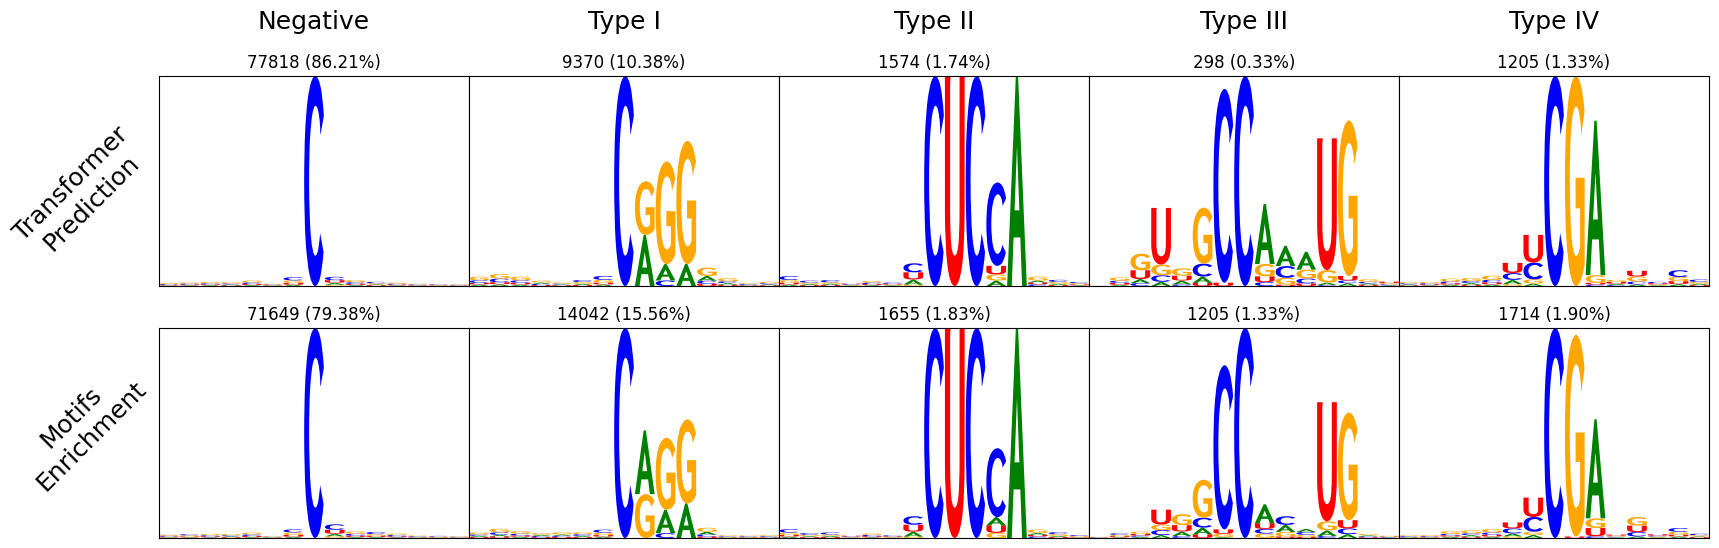

In [ ]:
import matplotlib.pyplot as plt
import logomaker
n = 5

fig, axes = plt.subplots(2, n,
                         figsize=(4*n, 3*2),
                         sharex=False, sharey=False)
fig.subplots_adjust(wspace=0)

axes[0,0].text(-0.25, 0.1,  "Transformer\nPrediction", transform=axes[0,0].transAxes,
        ha='center', va='bottom', fontsize=18, rotation=45)
axes[1,0].text(-0.25, 0.2,  "Motifs\nEnrichment", transform=axes[1,0].transAxes,
        ha='center', va='bottom', fontsize=18, rotation=45)

class_names = ["Negative", "Type I", "Type II", "Type III", "Type IV"]
n = len(class_names)
for i in range(n):
    ax = axes[0, i]
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(0.5, 1.2, class_names[i], transform=ax.transAxes,
        ha='center', va='bottom', fontsize=18)
    
    idxs = np.where((all_preds == i))[0]
    ax.set_title(f"{len(idxs)} ({100*len(idxs)/len(all_preds):.2f}%)")
    if len(idxs) < 40:
            #color in gray
            ax.set_facecolor("lightgray")
            ax.text(0.5, 0.5, f"n = {len(idxs)}", ha='center', va='center', fontsize=12)
            continue
    current = all_input_ids[idxs]
    pwm = np.sum(current, axis=0) / np.sum(np.sum(current, axis=0), axis=-1).reshape(-1, 1)
    pwm = pwm[pwm.shape[0]//2 - 7: pwm.shape[0]//2 + 8]
    pwm = pwm + 1e-9
    pwm = pwm / np.sum(pwm, axis=-1).reshape(-1, 1)
    pwm = pd.DataFrame(pwm, columns=["A","C","G","U"])
    info_df = logomaker.transform_matrix(pwm,
                                     from_type='probability',
                                     to_type='information')
        
    logo = logomaker.Logo(info_df, ax=ax, font_name='inconsolata',)

tot_seqs = 0
for motif, seqs in motifs_for_motif.items():
    tot_seqs += len(seqs)

for i in range(n):
    ax = axes[1, i]
    ax.set_xticks([])
    ax.set_yticks([])
    seqs = motifs_for_motif[class_names[i]]
    ax.set_title(f"{len(seqs)} ({100*len(seqs)/tot_seqs:.2f}%)")
    if len(seqs) < 40:
        #color in gray
        ax.set_facecolor("lightgray")
        ax.text(0.5, 0.5, f"n = {len(seqs)}", ha='center', va='center', fontsize=12)
        continue
    current = np.array(seqs)
    pwm = np.sum(current, axis=0) / np.sum(np.sum(current, axis=0), axis=-1).reshape(-1, 1)
    pwm = pwm[pwm.shape[0]//2 - 7: pwm.shape[0]//2 + 8]
    pwm = pwm + 1e-9
    pwm = pwm / np.sum(pwm, axis=-1).reshape(-1, 1)
    pwm = pd.DataFrame(pwm, columns=["A","C","G","U"])
    info_df = logomaker.transform_matrix(pwm,
                                     from_type='probability',
                                     to_type='information')
    
    logo = logomaker.Logo(info_df, ax=ax, font_name='inconsolata',)

to_save = CURRENT_DIR / "results/atlas_analysis/atlas_motifs_both.pdf"
plt.savefig(to_save, bbox_inches='tight')

